## Import basic packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
sns.set()

import tejapi
tejapi.ApiConfig.api_key = 'Your Key'
tejapi.ApiConfig.ignoretz = True


Bad key The font.family property has five values in file /Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc, line 211 ('The font.family property has five values:')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key The font.family property has five values in file /Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc, line 211 ('The font.family property has five values:')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution


## Load data & Preprocessing

### Price Data

In [2]:
data_price = tejapi.get('TWN/EWPRCD', # 公司交易資料-收盤價
                  coid= '0050', # 台灣50
                  mdate={'gte': '2003-01-01', 'lte':'2021-12-31'},
                  opts={'columns': ['coid', 'mdate', 'close_d', ]},
                  chinese_column_name=True,
                  paginate=True)
data_price = data_price.set_index('日期')
data_price.head()

,證券碼,收盤價
日期,,
2003-06-30,0050,37.08
2003-07-01,0050,38.05
2003-07-02,0050,38.69
2003-07-03,0050,39.00
2003-07-04,0050,39.26


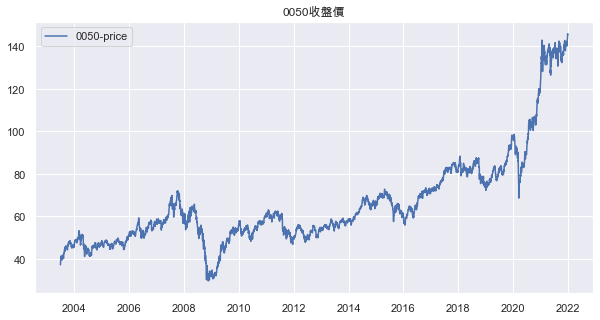

In [3]:
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(data_price['收盤價'], label = '0050-price')
plt.title('0050收盤價')
plt.legend()

In [4]:
from statsmodels.tsa.stattools import adfuller

price_p_value = adfuller(data_price['收盤價'])[1]
print('股價ADF-P值:', '{:.5f}'.format(price_p_value))
if price_p_value > 0.05:
    print('Nonstationary')
else:
    print('Stationary')

股價ADF-P值: 0.99623
Nonstationary


### Return Data

In [5]:
data_ret = tejapi.get('TWN/EWPRCD2', # 報酬率資料
                  coid= '0050', # 台灣50
                  mdate={'gte': '2003-01-01', 'lte':'2021-12-31'},
                  opts={'col     umns': ['coid', 'mdate', 'roia', ]},
                  chinese_column_name=True,
                  paginate=True)
data_ret = data_ret.set_index('日期')
data_ret.head()

,證券碼,日報酬率(%),近一週報酬率(%),近一月報酬率(%),近一季報酬率(%),近一年報酬率(%)
日期,,,,,,
2003-06-30,0050,0.2704,0.2704,0.2704,0.2704,0.2704
2003-07-01,0050,2.6160,2.8935,2.8935,2.8935,2.8935
2003-07-02,0050,1.6820,4.6241,4.6241,4.6241,4.6241
2003-07-03,0050,0.8012,5.4624,5.4624,5.4624,5.4624
2003-07-04,0050,0.6667,6.1655,6.1655,6.1655,6.1655


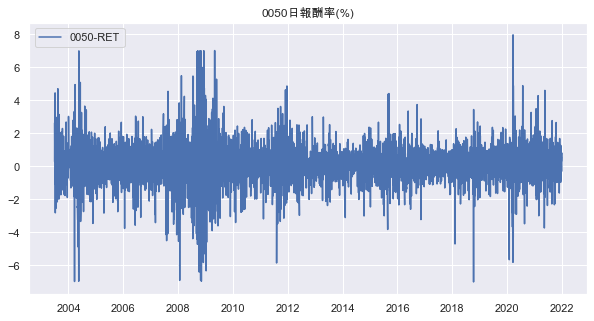

In [6]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(data_ret['日報酬率(%)'], label = '0050-RET')
plt.title('0050日報酬率(%)')
plt.legend()

In [7]:
ret_p_value = adfuller(data_ret['日報酬率(%)'])[1]
print('收益率ADF-P值:', '{:.5f}'.format(ret_p_value))
if ret_p_value > 0.05:
    print('Nonstationary')
else:
    print('Stationary')

收益率ADF-P值: 0.00000
Stationary


In [8]:
data = pd.concat([data_price, data_ret], axis = 1)
data = data.drop(columns = '證券碼')
data.head()

,收盤價,日報酬率(%),近一週報酬率(%),近一月報酬率(%),近一季報酬率(%),近一年報酬率(%)
日期,,,,,,
2003-06-30,37.08,0.2704,0.2704,0.2704,0.2704,0.2704
2003-07-01,38.05,2.6160,2.8935,2.8935,2.8935,2.8935
2003-07-02,38.69,1.6820,4.6241,4.6241,4.6241,4.6241
2003-07-03,39.00,0.8012,5.4624,5.4624,5.4624,5.4624
2003-07-04,39.26,0.6667,6.1655,6.1655,6.1655,6.1655


In [9]:
data = data.drop(columns = ['近一週報酬率(%)', '近一月報酬率(%)', '近一季報酬率(%)', '近一年報酬率(%)'])
data

,收盤價,日報酬率(%)
日期,,
2003-06-30,37.08,0.2704
2003-07-01,38.05,2.6160
2003-07-02,38.69,1.6820
2003-07-03,39.00,0.8012
2003-07-04,39.26,0.6667
...,...,...
2021-12-24,143.05,0.2804
2021-12-27,144.15,0.7690
2021-12-28,145.30,0.7978


In [10]:
train_date = data.index.get_level_values('日期') <= '2020-12-31'
train_data = data[train_date]
test_data = data[~train_date]

## ARIMA
### Apply pmdarima to find parameter

In [11]:
import pmdarima as pmd

In [12]:
pmd_mdl = pmd.auto_arima(train_data['日報酬率(%)'], stationary = True)
pmd_mdl.summary()

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1890: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4333
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -7102.571
Date:                Tue, 04 Jan 2022   AIC                          14217.143
Time:                        16:46:00   BIC                          14255.387
Sample:                             0   HQIC                         14230.645
                               - 4333                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0381      0.018      2.162      0.031       0.004       0.073
ar.L1          1.0387      0.021     49.846      0.000       0.998       1.080
ar.L2         -0.9459      0.020    -48.185      0.000      -0.984      -0.907
ma.L1         -1.0193      0.022    -46.626      0.000      -1.062      -0.976
ma.L2          0.9430      0.021     44.658      0.000       0.902       0.984
sigma2         1.5557      0.017     88.993      0.000       1.521       1.590
===================================================================================
Ljung-Box (L1) (Q):                   7.36   Jarque-Bera (JB):              5879.17
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data['日報酬率(%)'], order = (2, 0, 2))
stats_mdl = model.fit() 
print(stats_mdl.summary())

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: Use

                               SARIMAX Results                                
Dep. Variable:                日報酬率(%)   No. Observations:                 4333
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -7101.872
Date:                Tue, 04 Jan 2022   AIC                          14215.744
Time:                        16:46:04   BIC                          14253.988
Sample:                             0   HQIC                         14229.246
                               - 4333                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0483      0.019      2.536      0.011       0.011       0.086
ar.L1          1.0937      0.015     73.305      0.000       1.064       1.123
ar.L2         -0.9750      0.014    -69.490      0.0

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Residual Diagnosis

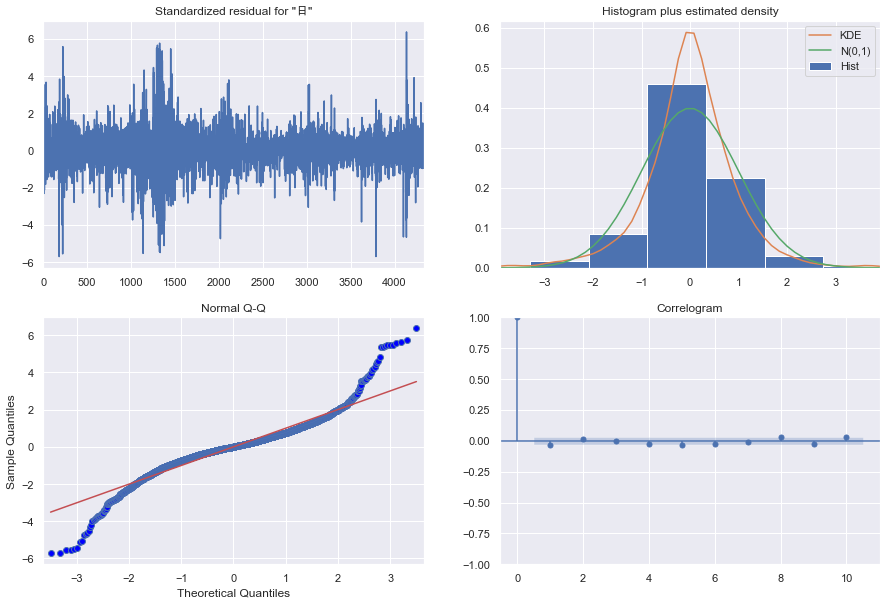

In [14]:
stats_mdl.plot_diagnostics(figsize = (15, 10))
plt.show()

### Ljung-Box test

In [16]:
from statsmodels.stats.diagnostic import acorr_ljungbox

arima_resid = pmd_mdl.arima_res_.resid

white_noise_arima = acorr_ljungbox(arima_resid, lags = [10], return_df=True)
white_noise_arima

,lb_stat,lb_pvalue
10,25.470309,0.004522


## GARCH

### ARCH Effect

In [58]:
from statsmodels.stats.diagnostic import het_arch

LM_pvalue = het_arch(arima_resid, ddof = 4)[1]
print('LM-test-Pvalue:', '{:.5f}'.format(LM_pvalue))

LM-test-Pvalue: 0.00000


### ACF & PACF

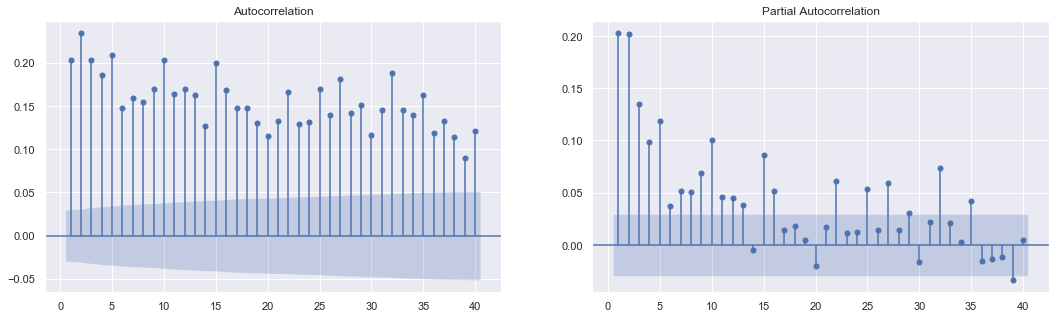

In [87]:
import statsmodels.graphics.tsaplots as sgt
fig, ax = plt.subplots(1, 2, figsize = (18,5))

sgt.plot_acf(arima_resid**2, zero = False, lags = 40, ax=ax[0])
sgt.plot_pacf(arima_resid**2, zero = False, lags = 40, ax=ax[1])

plt.show()

In [18]:
from arch import arch_model

In [88]:
mdl_garch = arch_model(arima_resid, vol = 'GARCH', p = 1, q = 1)
garch_fit = mdl_garch.fit()
garch_fit.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 32240.613293619484
Iteration:      2,   Func. Count:     16,   Neg. LLF: 26498.31472519534
Iteration:      3,   Func. Count:     26,   Neg. LLF: 879705987.3475063
Iteration:      4,   Func. Count:     32,   Neg. LLF: 6538.436511216547
Iteration:      5,   Func. Count:     38,   Neg. LLF: 7922.286114052655
Iteration:      6,   Func. Count:     44,   Neg. LLF: 11084.562405487024
Iteration:      7,   Func. Count:     50,   Neg. LLF: 6536.386191895961
Iteration:      8,   Func. Count:     56,   Neg. LLF: 6497.098675780244
Iteration:      9,   Func. Count:     61,   Neg. LLF: 6497.009789289936
Iteration:     10,   Func. Count:     66,   Neg. LLF: 6497.004822638634
Iteration:     11,   Func. Count:     72,   Neg. LLF: 6496.902008474386
Iteration:     12,   Func. Count:     77,   Neg. LLF: 6496.900970821283
Iteration:     13,   Func. Count:     82,   Neg. LLF: 6496.900963947306
Iteration:     14,   Func. Count:     86,   Neg. LLF: 6496.900

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6496.90
Distribution:                  Normal   AIC:                           13001.8
Method:            Maximum Likelihood   BIC:                           13027.3
                                        No. Observations:                 4333
Date:                Tue, Jan 04 2022   Df Residuals:                     4332
Time:                        21:58:21   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0325  1.515e-02      2.145  3.194e-02 [2.805e-03,6.218e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0189  6.353e-03      2.972  2.957e-03 [6.431e-03,3.133e-02]
alpha[1]       0.0605  1.154e-02      5.242  1.590e-07 [3.786e-02,8.309e-02]
beta[1]        0.9261  1.358e-02     68.214      0.000     [  0.899,  0.953]
============================================================================

Covariance estimator: robust
"""

In [80]:
mdl_garch = arch_model(arima_resid, vol = 'GARCH', p = 2, q = 1)
garch_fit = mdl_garch.fit()
garch_fit.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 31514.67478844573
Iteration:      2,   Func. Count:     18,   Neg. LLF: 46823606059.83218
Iteration:      3,   Func. Count:     28,   Neg. LLF: 862244505.3011956
Iteration:      4,   Func. Count:     35,   Neg. LLF: 6523.609765434216
Iteration:      5,   Func. Count:     42,   Neg. LLF: 7975.8611019603595
Iteration:      6,   Func. Count:     49,   Neg. LLF: 6498.0950778464585
Iteration:      7,   Func. Count:     56,   Neg. LLF: 6520.599427436644
Iteration:      8,   Func. Count:     63,   Neg. LLF: 6507.189874763049
Iteration:      9,   Func. Count:     70,   Neg. LLF: 6497.298197224302
Iteration:     10,   Func. Count:     77,   Neg. LLF: 6495.851041011195
Iteration:     11,   Func. Count:     83,   Neg. LLF: 6495.838540770073
Iteration:     12,   Func. Count:     89,   Neg. LLF: 6495.838518952918
Iteration:     13,   Func. Count:     95,   Neg. LLF: 6495.838518111169
Optimization terminated successfully    (Exit mode 0)
        

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6495.84
Distribution:                  Normal   AIC:                           13001.7
Method:            Maximum Likelihood   BIC:                           13033.5
                                        No. Observations:                 4333
Date:                Tue, Jan 04 2022   Df Residuals:                     4332
Time:                        19:07:31   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0327  1.520e-02      2.153  3.129e-02 [2.939e-03,6.251e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0213  8.265e-03      2.579  9.903e-03  [5.118e-03,3.752e-02]
alpha[1]       0.0438  1.893e-02      2.316  2.058e-02  [6.733e-03,8.094e-02]
alpha[2]       0.0227  2.656e-02      0.854      0.393 [-2.936e-02,7.476e-02]
beta[1]        0.9184  1.957e-02     46.929      0.000      [  0.880,  0.957]
=============================================================================

Covariance estimator: robust
"""

In [81]:
mdl_garch = arch_model(arima_resid, vol = 'GARCH', p = 1, q = 2)
garch_fit = mdl_garch.fit()
garch_fit.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 30625.856677937798
Iteration:      2,   Func. Count:     17,   Neg. LLF: 52005548744.63443
Iteration:      3,   Func. Count:     26,   Neg. LLF: 971551661.1593641
Iteration:      4,   Func. Count:     33,   Neg. LLF: 6522.358994025212
Iteration:      5,   Func. Count:     40,   Neg. LLF: 8797.934414998665
Iteration:      6,   Func. Count:     47,   Neg. LLF: 6508.183344610154
Iteration:      7,   Func. Count:     54,   Neg. LLF: 6497.189101127681
Iteration:      8,   Func. Count:     60,   Neg. LLF: 6496.951258600403
Iteration:      9,   Func. Count:     66,   Neg. LLF: 6497.049160566475
Iteration:     10,   Func. Count:     73,   Neg. LLF: 6496.952240146623
Iteration:     11,   Func. Count:     80,   Neg. LLF: 6496.901348460109
Iteration:     12,   Func. Count:     86,   Neg. LLF: 6496.900963764258
Iteration:     13,   Func. Count:     91,   Neg. LLF: 6496.90096385423
Optimization terminated successfully    (Exit mode 0)
          

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6496.90
Distribution:                  Normal   AIC:                           13003.8
Method:            Maximum Likelihood   BIC:                           13035.7
                                        No. Observations:                 4333
Date:                Tue, Jan 04 2022   Df Residuals:                     4332
Time:                        19:07:31   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0325  1.519e-02      2.140  3.238e-02 [2.729e-03,6.226e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0189  6.588e-03      2.866  4.156e-03 [5.970e-03,3.179e-02]
alpha[1]       0.0605  1.474e-02      4.103  4.072e-05 [3.159e-02,8.936e-02]
beta[1]        0.9261      0.321      2.885  3.913e-03     [  0.297,  1.555]
beta[2]    3.0527e-11      0.308  9.906e-11      1.000     [ -0.604,  0.604]
============================================================================

Covariance estimator: robust
"""

In [82]:
mdl_garch = arch_model(arima_resid, vol = 'GARCH', p = 2, q = 2)
garch_fit = mdl_garch.fit()
garch_fit.summary()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 37953901903359.43
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2471088327.7611094
Iteration:      3,   Func. Count:     29,   Neg. LLF: 7296.506847989118
Iteration:      4,   Func. Count:     39,   Neg. LLF: 45122.99883249609
Iteration:      5,   Func. Count:     48,   Neg. LLF: 6507.618468939472
Iteration:      6,   Func. Count:     56,   Neg. LLF: 6495.8881938540035
Iteration:      7,   Func. Count:     64,   Neg. LLF: 6495.939800783937
Iteration:      8,   Func. Count:     72,   Neg. LLF: 6495.652600893593
Iteration:      9,   Func. Count:     80,   Neg. LLF: 6495.644724046467
Iteration:     10,   Func. Count:     87,   Neg. LLF: 6495.64466542397
Iteration:     11,   Func. Count:     94,   Neg. LLF: 6495.6446615177665
Iteration:     12,   Func. Count:    100,   Neg. LLF: 6495.644661518077
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6495.6446615177665
            Iterations: 1

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6495.64
Distribution:                  Normal   AIC:                           13003.3
Method:            Maximum Likelihood   BIC:                           13041.5
                                        No. Observations:                 4333
Date:                Tue, Jan 04 2022   Df Residuals:                     4332
Time:                        19:07:31   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0325  1.521e-02      2.134  3.284e-02 [2.648e-03,6.228e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0271  1.115e-02      2.434  1.495e-02 [5.283e-03,4.901e-02]
alpha[1]       0.0433  1.812e-02      2.388  1.693e-02 [7.760e-03,7.878e-02]
alpha[2]       0.0414  3.215e-02      1.289      0.198  [-2.159e-02,  0.104]
beta[1]        0.6237      0.426      1.464      0.143     [ -0.211,  1.458]
beta[2]        0.2725      0.399      0.682      0.495     [ -0.510,  1.055]
============================================================================

Covariance estimator: robust
"""

### Residual Diagnosis

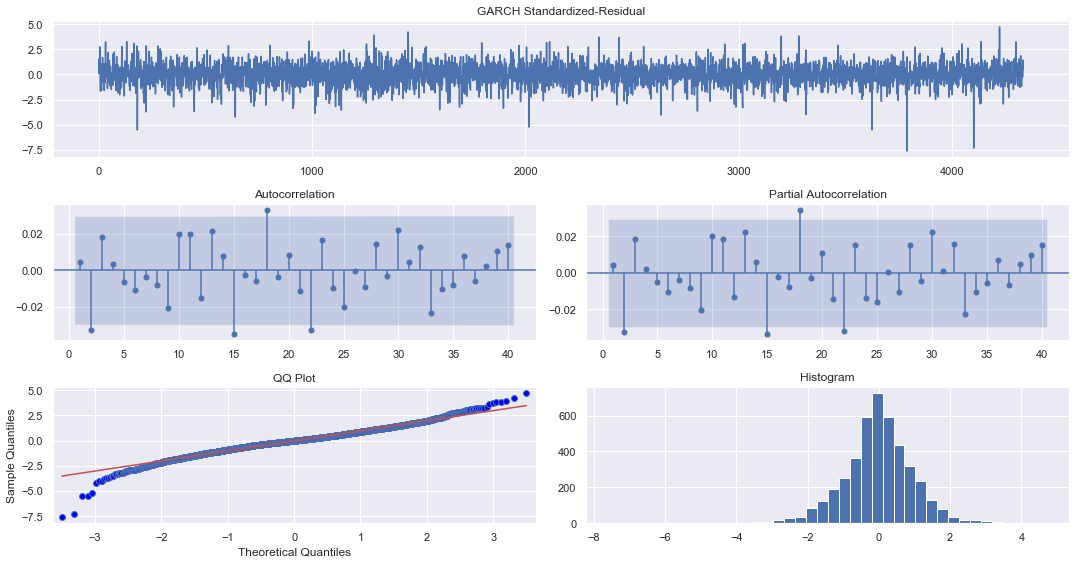

In [89]:
import statsmodels.api as sm

garch_std_resid = pd.Series(garch_fit.resid / garch_fit.conditional_volatility)
fig = plt.figure(figsize = (15, 8))

# Residual
garch_std_resid.plot(ax = fig.add_subplot(3,1,1), title = 'GARCH Standardized-Residual', legend = False)

# ACF/PACF
sgt.plot_acf(garch_std_resid, zero = False, lags = 40, ax=fig.add_subplot(3,2,3))
sgt.plot_pacf(garch_std_resid, zero = False, lags = 40, ax=fig.add_subplot(3,2,4))

# QQ-Plot & Norm-Dist
sm.qqplot(garch_std_resid, line='s', ax=fig.add_subplot(3,2,5)) 
plt.title("QQ Plot")
fig.add_subplot(3,2,6).hist(garch_std_resid, bins = 40)
plt.title("Histogram")

plt.tight_layout()
plt.show()

### Ljung-Box test

In [90]:
white_noise_garch = acorr_ljungbox(garch_std_resid, lags = [10], return_df=True)
white_noise_garch

,lb_stat,lb_pvalue
10,10.787973,0.374274
